In [1]:
# Import libraries and packages

import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns', 70)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns
import seaborn as sns; sns.set_context('talk')
sns.set(rc = {'figure.figsize' : (11, 4)})

import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_score, accuracy_score, f1_score, recall_score

from scipy.stats import randint

from pickle import dump

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import random

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Model Cleaning

Prior to building our classification models we need to convert all of our desired data into numbers the model can interpret. We do this by converting our categorical data into dummies represented with binary numbers.

In [2]:
# Convert features into binary values

In [3]:
df = pd.read_csv('Terry_Stops_Clean.csv')

In [4]:
# Change column values to binary only

# Call type 
df = df.replace({'call_type': {'911':'call',
                               'SCHEDULED EVENT (RECURRING)':'call', 
                               'ONVIEW':'onview',
                               'TELEPHONE OTHER, NOT 911':'call',
                               'ALARM CALL (NOT POLICE ALARM)':'call',
                               'TEXT MESSAGE':'call',
                               'PROACTIVE (OFFICER INITIATED)':'onview'}})

df.call_type = np.where(df.call_type == 'call', 0, df.call_type)
df.call_type = np.where(df.call_type == 'onview', 1, df.call_type)

# Stop resolution is the target, where arrest is 1
df = df.replace({'stop_resolution': {'Offense Report':0,
                                     'Arrest':1,
                                     'Field Contact':0,
                                     'Referred for Prosecution':0,
                                     'Citation / Infraction':0}})

# Frisk
df.frisk_flag = np.where(df.frisk_flag == 'N', 0, df.frisk_flag)
df.frisk_flag = np.where(df.frisk_flag == 'Y', 1, df.frisk_flag)

# Subject gender
df.subj_perceived_gender = np.where(df.subj_perceived_gender == 'Male', 0, df.subj_perceived_gender)
df.subj_perceived_gender = np.where(df.subj_perceived_gender == 'Female', 1, df.subj_perceived_gender)

# Officer gender
df.off_gender = np.where(df.off_gender == 'M', 0, df.off_gender)
df.off_gender = np.where(df.off_gender == 'F', 1, df.off_gender)


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [5]:
# Validate binary
print(df.call_type.unique())
print(df.stop_resolution.unique())
print(df.frisk_flag.unique())
print(df.subj_perceived_gender.unique())
print(df.off_gender.unique())

[nan 0 1]
[1 0]
[ 0. nan  1.]
[0 nan 1]
[0 1]


In [6]:
# Convert columns to category datatype
for col in ['beat', 'subj_age_group', 'weapon', 'subj_perceived_gender', 
            'off_race', 'subj_perceived_race', 'call_type']:
    df[col] = df[col].astype('category')

In [7]:
# Get dummies
dummies_df = pd.get_dummies(df, columns=["subj_age_group"], prefix=["subj_age"])
dummies_df = pd.get_dummies(df, columns=['weapon'], prefix=['weapon'])
dummies_df = pd.get_dummies(df, columns=["subj_perceived_gender"], prefix=["subj_gender"])
dummies_df = pd.get_dummies(df, columns=["off_race"], prefix=["off_race"])
dummies_df = pd.get_dummies(df, columns=["subj_perceived_race"], prefix=["subj_race"])
dummies_df = pd.get_dummies(df, columns=["call_type"], prefix=["call_type"])
dummies_df = pd.get_dummies(df, columns=["beat"], prefix=["beat"])
dummies_df = pd.get_dummies(df, columns=["subj_age_group"], prefix=["subj_age"])

dummies_df = dummies_df[dummies_df['call_type'] != 'None']

dummies_df = pd.get_dummies(df)

In [8]:
dummies_df.to_csv('Terry_Stops_Model.csv', index=False)

In [66]:
"""cat_df = pd.read_csv('Terry_Stops_Model.csv')"""

"cat_df = pd.read_csv('Terry_Stops_Model.csv')"

# Metrics Explained

Our target variable is stop_resolution, meaning we are looking to predict whether a stop results in an arrest (1) or not (0). In the dataset, an arrest occurs 24% of the time. 

The following evaluation metrics will be used across the models below to determine which one has the greatest predictive power. This is how they can be interpreted:

*True Positive*: Arresting someone who is guilty.

*False Positive*: Arresting someone who is not guilty.

*True Negative*: Not arresting someone who is not guilty.

*False Negative*: Not arresting someone who is guilty.

*Accuracy (TP+TN/TP+FP+FN+TN)*: Accuracy is the ratio of correctly predicted observations to the total observations. Accuracy is a great measure only when you have symmetric datasets where values of false positive and false negatives are almost the same. This is the ratio of correctly predicted guilty arrests and not guilty non-arrests, out of the total population of guilty and innocent subjects. 

*Precision (TP/TP+FP)*: Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. This is the ratio of correctly predicted guilty arrests out of everyone arrested (some of which will not be guilty). 

*Recall (TP/TP+FN)*: Recall is the ratio of correctly predicted positive observations to the all observations in actual class. Or, everyone correctly arrested because they are guilty, out of everyone guilty (some of which were missed and not arrested).

*F1 (2x(Recall x Precision) / (Recall + Precision))*: F1 Score is the weighted average of Precision and Recall, thereby taking both false positives and false negatives into account. F1 ranges from 0 to 1, with a better score being higher. 

Which metric matters?

The answer depends on the specific issue at hand and the subjective point of view of the person answering. If arresting someone who is not guilty was the worst (or if you want the smallest number of False Positives possible), then one would choose the model which has the best precision score. The best precision score would be the highest one because it would have the smallest # of FP in the denominator. Similarly, the F1 score would also be important.

# Baseline Model

A baseline of data on which classificiation algorithms will be used is established below. The desired features and target are specified, the training and testing data is split, data is randomized and a search for the hyperparameters that would enable the algorithms to drive the most accurate predictions is performed.

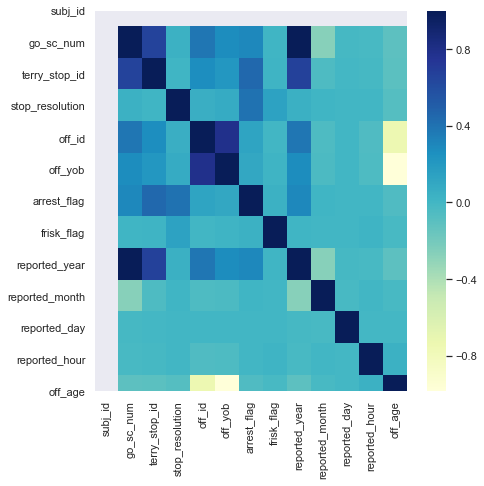

In [10]:
# View correlation between variables 
fig, ax = plt.subplots(figsize=(7,7))
corr = df.corr()
sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [11]:
# Pick features
features_df = cat_df.filter(['call_type_1',
                             'call_type_0',
                             'weapon_Blade',
                             'beat_M',
                             'beat_U',
                             'beat_K',
                             'beat_E',
                             'beat_F',
                             'off_race_White',
                             'subj_perceived_race_White',
                             'subj_perceived_race_Black or African American',
                             'off_age',
                             'date'], axis=1)

In [12]:
# View % distribution in target
cat_df.stop_resolution.value_counts(normalize=True)

0    0.75899
1    0.24101
Name: stop_resolution, dtype: float64

The above means 76% of the time a stop resolution does not lead to an arrest and 24% of the time it does.

In [13]:
# Check target is binary
dummies_df.stop_resolution.unique()

array([1, 0])

In [14]:
# Split training & testing data
from sklearn.model_selection import train_test_split

y = dummies_df['stop_resolution']
X = dummies_df.drop(['stop_resolution'], axis=1)
X = features_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [15]:
# View shape
print(y.shape)
print(X.shape)

(42853,)
(42853, 12)


##### Dummy Classifier
DummyClassifier is used below to make predictions using simple rules. This classifier is useful as a baseline to compare with other (real) classifiers.

In [16]:
# Load dummy classifier
dc = DummyClassifier()

In [17]:
# Fit on training data 
dc.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [18]:
# Make predictions 
dummy_pred = dc.predict(X_test)

##### Dummy Scores

In [19]:
# Scores
print(precision_score(y_test, dummy_pred))
print(f1_score(y_test, dummy_pred))
print(accuracy_score(y_test, dummy_pred))
print(recall_score(y_test, dummy_pred))

0.23441199684293607
0.23103850641773627
0.6309501586708979
0.227760736196319


##### SMOTE and Ethics

SMOTE is used below to address class imbalance problems in our data. As we see from the target (stop_resolution) count, arrests are the minority. Synthetic Minority Oversampling generates new sample data by creating 'synthetic' examples that are combinations of the closest minority class cases.

It is worth noting here that SMOTE can be controvercial when working with a dataset on real people. There are ethical concerns when creating synthetic data representing people because the synthetics can amplify existing bias in the historical data. 

In [20]:
# SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=23)
X_train_SMOTE, y_train_SMOTE = smote.fit_sample(X_train, y_train)

In [21]:
# Fit logistic regression on data balanced with SMOTE
logreg = LogisticRegression(multi_class='ovr')
logreg.fit(X_train_SMOTE,y_train_SMOTE)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
# Predict on testing data
y_pred_base = logreg.predict(X_test)

##### Baseline Scores

In [59]:
# Compare predictions to actuals to generate scores
print("Prec:",metrics.precision_score(y_test, y_pred_base))
print("F1:",metrics.f1_score(y_test, y_pred_base))

print("Acc:",metrics.accuracy_score(y_test, y_pred_base))
print("Rec:",metrics.recall_score(y_test, y_pred_base))

Prec: 0.33143191458241916
F1: 0.4798305982001058
Acc: 0.5414411050961359
Rec: 0.8688650306748467


In [24]:
# Confusion matrix
print(confusion_matrix(y_test, y_pred_base))
# Classification report
print(classification_report(y_test, y_pred_base))

[[3535 4571]
 [ 342 2266]]
              precision    recall  f1-score   support

           0       0.91      0.44      0.59      8106
           1       0.33      0.87      0.48      2608

    accuracy                           0.54     10714
   macro avg       0.62      0.65      0.53     10714
weighted avg       0.77      0.54      0.56     10714



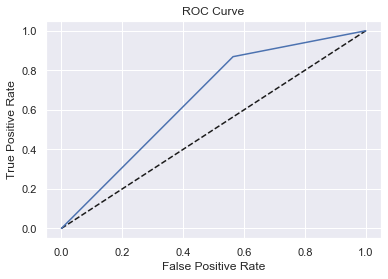

In [25]:
# Generate ROC curve values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base)

# Plot ROC curve
_=plt.plot([0, 1], [0, 1], 'k--')
_=plt.plot(fpr, tpr)
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('ROC Curve')
plt.show()

In [26]:
# Calculate null accuracy
max(y_test.mean(), 1 - y_test.mean())

0.7565801754713459

The above indicates that a dumb model that always predicts 0 would be right 76% of the time. This provides a minimum to achieve with the model.

# Random Forest Classifier

The Random Forest Classifier is an ensemble of decision trees that are trained to use bagging, or a combination of learning models, to obtain a more accurate and stable prediction. RFC is effective because of its randomness; instead of searching for the most important feature while building a tree, it searches for the best feature among a random subset of features only. When a a random subset of the features is taken into account when spliting a node, the model is able to more effectively find the features that are the most important in yielding an accurate outcome. RFC allows you to measure a feature's importance by looking at how much the tree nodes that use that feature reduce impurity across all trees in the forest.

##### Grid Search CV

Combinatorial grid search is used below to find the best combination of parameters to improve model performance. Grid search performs an exhaustive search of every single combination from which to select the best parameters. Since Gridsearch is a computationally expensive task, it is set up with n_jobs = -1 to run things in parallel across all cores in the computer.

In [27]:
# Random forest parameter grid
rfc_param_grid = { 
    'class_weight': ['balanced','balanced_subsample'],
    'n_estimators': [350, 400, 450],
    'min_impurity_decrease': [.0001,.00001],
    'max_depth': [30, 40, 50]
}

##### RFC Imbalanced Weight

In [28]:
# Establish rfc with gridsearch where class weight is balanced
rfc = RandomForestClassifier()
grid_rfc = GridSearchCV(rfc, rfc_param_grid, cv = 3, n_jobs = -1, scoring = 'precision', verbose = 1)

In [29]:
# Fit Random Forest Classifier on data
grid_rfc.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [30]:
# Print best parameters and estimator
print(grid_rfc.best_params_)
print(grid_rfc.best_estimator_)

{'class_weight': 'balanced', 'max_depth': 50, 'min_impurity_decrease': 1e-05, 'n_estimators': 400}
RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=1e-05,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=400, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


In [31]:
# Predict on the test set
y_pred_grid=grid_rfc.best_estimator_.predict(X_test)

##### RFC Imbalanced Weight Scores

In [63]:
# Scores
print("Prec:",metrics.precision_score(y_test, y_pred_grid))
print("F1:",metrics.f1_score(y_test, y_pred_grid))

print("Acc:",metrics.accuracy_score(y_test, y_pred_grid))
print("Rec:",metrics.recall_score(y_test, y_pred_grid))

Prec: 0.3422657252888318
F1: 0.48257918552036194
Acc: 0.5730819488519694
Rec: 0.8178680981595092


In [33]:
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))

[[4020 4086]
 [ 476 2132]]
              precision    recall  f1-score   support

           0       0.89      0.50      0.64      8106
           1       0.34      0.82      0.48      2608

    accuracy                           0.57     10714
   macro avg       0.62      0.66      0.56     10714
weighted avg       0.76      0.57      0.60     10714



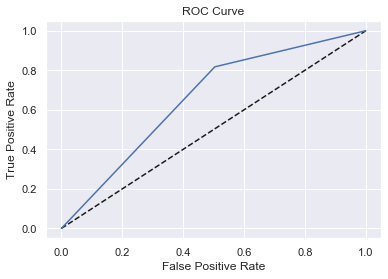

In [34]:
# Generate ROC curve values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_grid)

# Plot ROC curve
_=plt.plot([0, 1], [0, 1], 'k--')
_=plt.plot(fpr, tpr)
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('ROC Curve')
plt.show()

##### RFC Balanced Weight

Since we know that our target is imbalanced (an arrest only happens 24% of the time), we can make the classifier aware of the imbalanced data by incorporating the weights of the classes into the cost function, by using the utility function class_weight = 'balanced'. Intuitively, we want to give higher weight to the minority class (an arrest) and lower weight to the majority class (non-arrest). 

In [35]:
# Establish rfc with gridsearch where class weight is balanced
rfc = RandomForestClassifier(class_weight='balanced')
grid_rfc = GridSearchCV(rfc, rfc_param_grid, cv = 3, n_jobs = -1, scoring = 'precision', verbose = 1)

In [36]:
# Fit Random Forest Classifier on data
grid_rfc.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

In [37]:
#  Print best parameters and estimator
print(grid_rfc.best_params_)
print(grid_rfc.best_estimator_)

{'class_weight': 'balanced', 'max_depth': 30, 'min_impurity_decrease': 1e-05, 'n_estimators': 350}
RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=1e-05,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=350, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


In [38]:
# Predict on the test set
y_pred_grid=grid_rfc.best_estimator_.predict(X_test)

##### RFC Balanced Weight Scores

In [62]:
# Get F1, accuracy, precision, and recall scores
print("Prec:",metrics.precision_score(y_test, y_pred_grid))
print("F1:",metrics.f1_score(y_test, y_pred_grid))

print("Acc:",metrics.accuracy_score(y_test, y_pred_grid))
print("Rec:",metrics.recall_score(y_test, y_pred_grid))

Prec: 0.3422657252888318
F1: 0.48257918552036194
Acc: 0.5730819488519694
Rec: 0.8178680981595092


In [40]:
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))

[[4007 4099]
 [ 475 2133]]
              precision    recall  f1-score   support

           0       0.89      0.49      0.64      8106
           1       0.34      0.82      0.48      2608

    accuracy                           0.57     10714
   macro avg       0.62      0.66      0.56     10714
weighted avg       0.76      0.57      0.60     10714



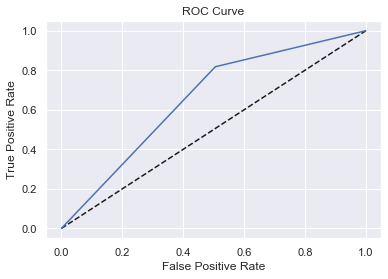

In [41]:
# Generate ROC curve values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_grid)

# Plot ROC curve
_=plt.plot([0, 1], [0, 1], 'k--')
_=plt.plot(fpr, tpr)
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('ROC Curve')
plt.show()

##### Feature Importance
Feature selection is an important step in model tuning because it reduces dimensionality which improves the model speed and performance.

In [42]:
# List of features in order of importance
feat_importances = pd.Series(grid_rfc.best_estimator_.feature_importances_, index=X.columns)
df_feat_importances = pd.DataFrame(feat_importances)
df_feat_importances.sort_values(by=[0], ascending=False)

,0
call_type_0,0.341806
off_age,0.229176
call_type_1,0.217346
beat_M,0.047565
weapon_Blade,0.040401
beat_E,0.030271
beat_K,0.023323
off_race_White,0.018449
subj_perceived_race_Black or African American,0.017445
subj_perceived_race_White,0.013908


Overall, the most important features appear to be when the officer was called to the location (via 911, text etc.), if the location was in a high-crime beat, if the subject had a blade as a weapon, if the officer or subject race was white or if the subject race was black. These features will be used in classification models to predict whether a stop will result in an arrest or not (where stop_resolution = 1 for arrest and 0 for all others).

# Logistic Regression

Logistic regression predicts categorical (binomial/multinomial) outcomes in the form of probabilities by using  a cross-entropy cost function known as Log Loss. Logarithmic loss measures the performance of a classification model where probability ranges between 0 and 1. Log loss increases as the predicted probability diverges from the actual. Therefore, the goal of our logarithmic regression model is to minimize the log loss and hence approach 1 for the predicted probability, wherein the prediction is as close to the actual value as possible.

In [43]:
# Logistic regression parameter grid
log_param_grid = { 
    'fit_intercept': ['True', 'False'],
    'intercept_scaling': [1,.01,.001,.0001],
    'C': [1,0.01,0.1,0.0001],
    'tol': [0.01,0.001,0.0001],
    'max_iter': [50,100,150,200]
}

##### LR Imbalanced Weight

In [44]:
logreg = LogisticRegression(multi_class='ovr', solver = 'liblinear')
grid_logreg = GridSearchCV(logreg, log_param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid_logreg.fit(X_train_SMOTE,y_train_SMOTE)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:   17.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1, 0.01, 0.1, 0.0001],
                         'fit_intercept': ['True', 'False'],
                         'intercept_scaling': [1, 0.01, 0.001, 0.0001],
                         'max_iter': [50, 100, 150, 200],
                         'tol': [0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', re

In [45]:
# Predict on the test set
log_y_pred_grid=grid_logreg.best_estimator_.predict(X_test)

In [46]:
# Best parameters and best estimator
print(grid_logreg.best_params_)
print(grid_logreg.best_estimator_)

{'C': 1, 'fit_intercept': 'True', 'intercept_scaling': 1, 'max_iter': 50, 'tol': 0.001}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept='True',
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.001, verbose=0,
                   warm_start=False)


##### LR Imbalanced Weight Scores

In [64]:
# Print scores
print("Prec:",metrics.precision_score(y_test, y_pred_grid))
print("F1:",metrics.f1_score(y_test, y_pred_grid))

print("Acc:",metrics.accuracy_score(y_test, y_pred_grid))
print("Rec:",metrics.recall_score(y_test, y_pred_grid))

Prec: 0.3422657252888318
F1: 0.48257918552036194
Acc: 0.5730819488519694
Rec: 0.8178680981595092


In [48]:
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))

[[4007 4099]
 [ 475 2133]]
              precision    recall  f1-score   support

           0       0.89      0.49      0.64      8106
           1       0.34      0.82      0.48      2608

    accuracy                           0.57     10714
   macro avg       0.62      0.66      0.56     10714
weighted avg       0.76      0.57      0.60     10714



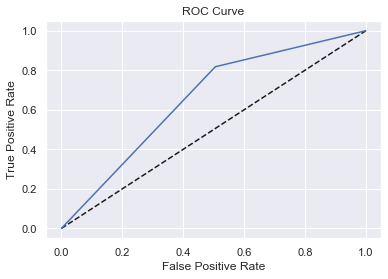

In [49]:
# Generate ROC curve values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_grid)

# Plot ROC curve
_=plt.plot([0, 1], [0, 1], 'k--')
_=plt.plot(fpr, tpr)
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('ROC Curve')
plt.show()

In [50]:
# Get coefficients
import statsmodels.api as sm
model = sm.Logit(cat_df.stop_resolution, cat_df[['call_type_1',
                             'call_type_0',
                             'weapon_Blade',
                             'beat_M',
                             'beat_U',
                             'beat_K',
                             'beat_E',
                             'beat_F',
                             'off_race_White',
                             'subj_perceived_race_White',
                             'subj_perceived_race_Black or African American',
                             'off_age']])
                            


In [51]:
# Get results
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.510079
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        stop_resolution   No. Observations:                42853
Model:                          Logit   Df Residuals:                    42841
Method:                           MLE   Df Model:                           11
Date:                Wed, 02 Dec 2020   Pseudo R-squ.:                 0.07635
Time:                        11:29:26   Log-Likelihood:                -21858.
converged:                       True   LL-Null:                       -23665.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
call_type_1                                       1.4082      0.038     36.863      0.000       1.333       1.483
call_type_0                                       1.4204      0.032     44.510      0.000       1.358       1.483
weapon_Blade                                      0.8020      0.051     15.646      0.000       0.702       0.903
beat_M                                            0.4289      0.042     10.235      0.000       0.347       0.511
beat_U                                           -0.1693      0.064     -2.658      0.008      -0.294      -0.044
beat_K                                            0.1107      0.044      2.543      0.011       0.025       0.196
beat_E                                            0.1912      0.042      4.516      0.000       0.108       0.274
beat_F                                           -0.1609      0.059     -2.724      0.006      -0.277      -0.045
off_race_White                                   -0.1805      0.027     -6.808      0.000      -0.232      -0.129
subj_perceived_race_White                        -0.2301      0.029     -7.967      0.000      -0.287      -0.174
subj_perceived_race_Black or African American    -0.0851      0.031     -2.729      0.006      -0.146      -0.024
off_age                                          -0.0594      0.001    -57.926      0.000      -0.061      -0.057
=================================================================================================================
"""

##### LR Balanced Weight

In [52]:
logreg = LogisticRegression(multi_class='ovr', solver = 'liblinear', class_weight = 'balanced')
grid_logreg = GridSearchCV(logreg, log_param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid_logreg.fit(X_train_SMOTE,y_train_SMOTE)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:   17.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1, 0.01, 0.1, 0.0001],
                         'fit_intercept': ['True', 'False'],
                         'intercept_scaling': [1, 0.01, 0.001, 0.0001],
                         'max_iter': [50, 100, 150, 200],
                         'tol': [0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_job

In [53]:
# Predict on the test set
log_y_pred_grid=grid_logreg.best_estimator_.predict(X_test)

In [54]:
# Best parameters and best estimator
print(grid_logreg.best_params_)
print(grid_logreg.best_estimator_)

{'C': 1, 'fit_intercept': 'True', 'intercept_scaling': 1, 'max_iter': 50, 'tol': 0.001}
LogisticRegression(C=1, class_weight='balanced', dual=False,
                   fit_intercept='True', intercept_scaling=1, l1_ratio=None,
                   max_iter=50, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.001, verbose=0,
                   warm_start=False)


##### LR Balanced Weight Scores

In [65]:
# Print scores
print("Prec:",metrics.precision_score(y_test, log_y_pred_grid))
print("F1:",metrics.f1_score(y_test, log_y_pred_grid))

print("Acc:",metrics.accuracy_score(y_test, log_y_pred_grid))
print("Rec:",metrics.recall_score(y_test, log_y_pred_grid))

Prec: 0.33143191458241916
F1: 0.4798305982001058
Acc: 0.5414411050961359
Rec: 0.8688650306748467


In [56]:
# Get results
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.510079
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        stop_resolution   No. Observations:                42853
Model:                          Logit   Df Residuals:                    42841
Method:                           MLE   Df Model:                           11
Date:                Wed, 02 Dec 2020   Pseudo R-squ.:                 0.07635
Time:                        11:29:43   Log-Likelihood:                -21858.
converged:                       True   LL-Null:                       -23665.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
call_type_1                                       1.4082      0.038     36.863      0.000       1.333       1.483
call_type_0                                       1.4204      0.032     44.510      0.000       1.358       1.483
weapon_Blade                                      0.8020      0.051     15.646      0.000       0.702       0.903
beat_M                                            0.4289      0.042     10.235      0.000       0.347       0.511
beat_U                                           -0.1693      0.064     -2.658      0.008      -0.294      -0.044
beat_K                                            0.1107      0.044      2.543      0.011       0.025       0.196
beat_E                                            0.1912      0.042      4.516      0.000       0.108       0.274
beat_F                                           -0.1609      0.059     -2.724      0.006      -0.277      -0.045
off_race_White                                   -0.1805      0.027     -6.808      0.000      -0.232      -0.129
subj_perceived_race_White                        -0.2301      0.029     -7.967      0.000      -0.287      -0.174
subj_perceived_race_Black or African American    -0.0851      0.031     -2.729      0.006      -0.146      -0.024
off_age                                          -0.0594      0.001    -57.926      0.000      -0.061      -0.057
=================================================================================================================
"""

In [57]:
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))

[[4007 4099]
 [ 475 2133]]
              precision    recall  f1-score   support

           0       0.89      0.49      0.64      8106
           1       0.34      0.82      0.48      2608

    accuracy                           0.57     10714
   macro avg       0.62      0.66      0.56     10714
weighted avg       0.76      0.57      0.60     10714



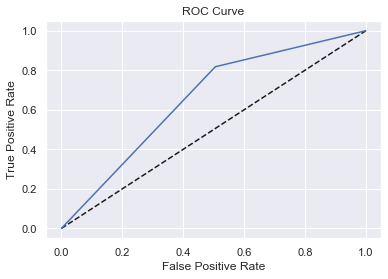

In [58]:
# Generate ROC curve values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_grid)

# Plot ROC curve
_=plt.plot([0, 1], [0, 1], 'k--')
_=plt.plot(fpr, tpr)
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('ROC Curve')
plt.show()

# Classification Result Summary

Here is a summary of our precision and F1 scores (which we designated as the most important in the context of this data):
    
- Dummy:

Precision: .23   
F1: .23
    
- Baseline:

Precision: .33   
F1: .48

- RFC Imbalanced:

Precision: .34   
F1: .48

- RFC Balanced:

Precision: .34   
F1: .48

- Logistic Regression Imbalanced:

Precision: .34   
F1: .48

- Logistic Regression Balanced:

Precision: .33   
F1: .48


Compared to a dummy baseline, both the RFC and LR were 10% more precise and had a 25% better F1 score. Balancing class weight did not make a difference.

The prediction metrics of the algorithms did not turn out to be substantially predictive. However, the exploratory data analysis provided insight into disparities of stops according to race and location of stops corresponding to areas with high crime.

Overall, the most predictive features were when:
- officer was called to the location (via 911, text etc.)
- location was in a high-crime beat
- subject had a blade 
- officer or subject race was white 
- subject race was black


# Ideas for Future Exploration
- Exploratory data analysis showed an over-representation of blacks, hispanics and native american frisks and arrests relative to the population. It would be interesting to evaluate - rather than the impact of subject race on stop resolutions - the impact of skin color on stop resolutions. That is, if I were to combine populations of darker skin color to those with lighter, whether that feature would have a more significant impact on the classification model in predicting arrest. Another option would be to evaluate the impact of white versus non-white on the model.
- A cluster analysis could investigate whether there are groups of officers that stop certain subjects. Likewise,  one could isolate whether there are outlier officers whose historical arrests are out of the norm for a specific area.
- A time series approach could identify stops or frisks of a class of subjects during certain times of day.